### Importing Libraries 

In [1]:
import cv2
import numpy as np
import imageio as iio
from matplotlib import pyplot as plt

#### get image and texture 

(512, 512)
(256, 256, 4)


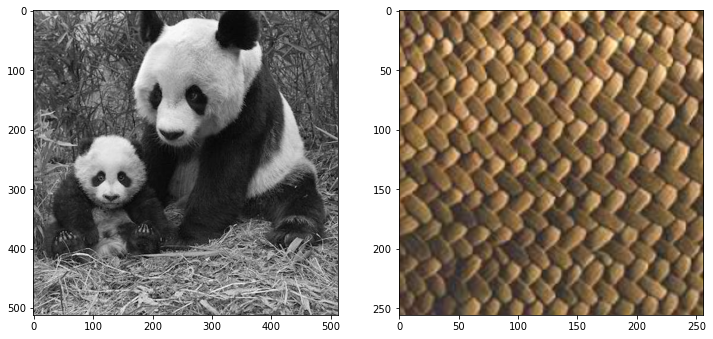

In [2]:
img = iio.imread("img5.jpg").astype('float32')
tex = iio.imread("tex5.jpg").astype('float32')
tex_gray = cv2.cvtColor(tex, cv2.COLOR_RGB2GRAY).astype('uint8')
print(img.shape)
print(tex.shape)
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(img,cmap='gray');
plt.subplot(1,2,2)
plt.imshow(tex.astype('uint8'),cmap='gray');

def scale(img):
    return (img-np.min(img))/(np.max(img)-np.min(img))*255

#### tot_cost simply calculates Ls, Lt errors depending on the location of block in the image(i,j)

In [9]:
def norm2(img1,img2): #get norm2 error
    return np.sum(np.sum((img1-img2)**2))

def tot_cost(img,trans,block,i,j,b=32,d=8,alpha=.2):
    #trans = cv2.cvtColor(trans, cv2.COLOR_BGR2GRAY)
    if i==0:
        Ls = norm2(trans[0:b,(j)*(b-d):(j)*(b-d)+d],block[0:b,0:d])
    if j==0:
        Ls = norm2(trans[i*(b-d):i*(b-d)+d,0:b],block[0:d,0:b])
    if i!=0 and j!=0:
        Ls1 = norm2(trans[i*(b-d):i*(b-d)+b,j*(b-d):j*(b-d)+d],block[0:b,0:d])
        Ls2 = norm2(trans[i*(b-d):i*(b-d)+d,(j)*(b-d):(j)*(b-d)+b],block[0:d,0:b])
        Ls = Ls1+Ls2
        #print("tot_cost",i,j)
    Lt = norm2(block,img[i*(b-d):i*(b-d)+b,j*(b-d):j*(b-d)+b])
    #print(Lt)
    return alpha*Ls+(1-alpha)*Lt

##### get_min_border is exactly the function implemented on HW5, it gets an image and gives the lowes cost path by dynamic programing
##### min_boundry_add gets the next block you want to add and depending on the location sets the border(two border for i,j !=0) and adds the block to final image 

In [10]:
def get_min_border(img):
    m,n = img.shape
    out = np.zeros((m,n)) # path itself
    costs = np.zeros((m,n),dtype=int) # cost till the node
    last = np.zeros((m,n)) # -1, 0, 1 upper node
    costs[0,0] = img[0,0]
    for i in range(m):
        for j in range(n):
            if(i>0):
                if (j==0):
                    costs[i,j] = img[i,j]+ min(costs[i-1,j],costs[i-1,j+1])
                elif (j==n-1):
                    costs[i,j] = img[i,j]+ min(costs[i-1,j],costs[i-1,j-1])
                else:
                    k = np.argmin(costs[i-1,j-1:j+2])
                    if j+k < n-1 and costs[i-1,j-1+k] == costs[i-1,j+k]:
                        k += 1 # not important, for keeping lines vertical
                    costs[i,j] = img[i,j]+costs[i-1,j-1+k]
                    last[i,j] = k-1
    l = np.argmin(costs[m-1,:])
    #plt.figure()
    #plt.imshow(costs,cmap='gray')
    out[m-1,l] = 1
    for i in range(2,m+1):
        k = last[m-i+1,l]
        l = int(l+k)
        out[m-i,l] = 1
    return out.astype("uint8")

def min_bound_add(trans,block,i,j,b=32,d=8):
    out = trans.copy()
    if i==0: #horizontal line
        left = cv2.cvtColor(trans[0:b,(j)*(b-d):(j)*(b-d)+d], cv2.COLOR_BGR2GRAY).astype("float64")
        right = cv2.cvtColor(block[0:b,0:d], cv2.COLOR_BGR2GRAY).astype("float64")
        diff = abs(left - right)**2
        #plt.imshow(scale(diff).astype('uint8'),cmap='gray')
        path = get_min_border(diff)
        #plt.imshow(scale(path).astype('uint8'),cmap='gray')
        mask = np.zeros(left.shape[:2])
        for i_m in range(path.shape[0]):
            k = np.argmax(path[i_m,:])
            mask[i_m,:k] = 1
        mask = np.dstack((mask,mask,mask,mask)).astype("uint8")
        #iio.imwrite("q5/path_mask.png",255*mask)
        out[0:b,j*(b-d):j*(b-d)+b] = block
        out[0:b,j*(b-d):j*(b-d)+d] = 1*mask*trans[0:b,(j)*(b-d):(j)*(b-d)+d] + (1-mask)*block[0:b,0:d]
    if j==0 : #vertical line
        left = cv2.cvtColor(trans[(i)*(b-d):(i)*(b-d)+d,0:b], cv2.COLOR_BGR2GRAY).astype("float64")
        right = cv2.cvtColor(block[0:d,0:b], cv2.COLOR_BGR2GRAY).astype("float64")
        diff = abs(left - right)**2
        #plt.imshow(scale(diff).astype('uint8'),cmap='gray')
        path = get_min_border(diff)
        #plt.imshow(scale(path).astype('uint8'),cmap='gray')
        mask = np.zeros(left.shape[:2])
        for i_m in range(path.shape[0]):
            k = np.argmax(path[i_m,:])
            mask[i_m,:k] = 1
        #print(i,j)
        mask = np.dstack((mask,mask,mask,mask)).astype("uint8")
        #iio.imwrite("q5/path_mask_vertical.png",255*mask)
        out[i*(b-d):i*(b-d)+b,0:b] = block
        out[i*(b-d):i*(b-d)+d,0:b] = 1*mask*trans[(i)*(b-d):(i)*(b-d)+d,0:b] + 1*(1-mask)*block[0:d,0:b]
    if i!=0 and j!=0: #middle blockes
        out[i*(b-d):i*(b-d)+b,j*(b-d):j*(b-d)+b] = block
        #vertical lines border
        left = cv2.cvtColor(trans[(i)*(b-d):(i)*(b-d)+d,j*(b-d):j*(b-d)+b], cv2.COLOR_BGR2GRAY).astype("float64")
        right = cv2.cvtColor(block[0:d,0:b], cv2.COLOR_BGR2GRAY).astype("float64")
        diff = abs(left - right)**2
        path = get_min_border(diff)
        mask = np.zeros(left.shape[:2])
        for i_m in range(path.shape[0]):
            k = np.argmax(path[i_m,:])
            mask[i_m,:k] = 1
        mask = np.dstack((mask,mask,mask,mask)).astype("uint8")
        out[i*(b-d):i*(b-d)+d,j*(b-d):j*(b-d)+b] = 1*mask*trans[(i)*(b-d):(i)*(b-d)+d,j*(b-d):j*(b-d)+b] + 1*(1-mask)*block[0:d,0:b]
        #horizontal lines border
        left = cv2.cvtColor(trans[i*(b-d):i*(b-d)+b,(j)*(b-d):(j)*(b-d)+d], cv2.COLOR_BGR2GRAY).astype("float64")
        right = cv2.cvtColor(block[0:b,0:d], cv2.COLOR_BGR2GRAY).astype("float64")
        diff = abs(left - right)**2
        path = get_min_border(diff)
        mask = np.zeros(left.shape[:2])
        for i_m in range(path.shape[0]):
            k = np.argmax(path[i_m,:])
            mask[i_m,:k] = 1
        mask = np.dstack((mask,mask,mask,mask)).astype("uint8")
        out[i*(b-d):i*(b-d)+b,j*(b-d):j*(b-d)+d] = 1*mask*trans[i*(b-d):i*(b-d)+b,(j)*(b-d):(j)*(b-d)+d] + (1-mask)*block[0:b,0:d]
    return out

In [11]:
b = 32 #block size
d = 8 #overlap size
out = np.zeros((img.shape[0],img.shape[1],4)).astype('float32')
x = np.random.randint(256-b)
y = np.random.randint(256-b)
out[0:b,0:b] = tex[x:x+b,y:y+b,:].copy()
N = tex.shape[0]//b #blocks to search in texture
#create firs row (like out2.png saved)
for i in range(img.shape[1]//(b-d)-1):
    min_cost = 10**10
    next_block = np.zeros((b,b,4))
    for x in range(N):
        for y in range(N):
            #block = tex[x*b:(x+1)*b,y*b:(y+1)*b]
            block = cv2.cvtColor(tex[x*b:(x+1)*b,y*b:(y+1)*b], cv2.COLOR_BGR2GRAY).astype('float32')
            trans = cv2.cvtColor(out, cv2.COLOR_RGB2GRAY).astype('float32')
            cost = tot_cost(img,trans,block,0,i+1)
            if(cost<min_cost):
                min_cost = cost
                next_block = tex[x*b:(x+1)*b,y*b:(y+1)*b]
    out = min_bound_add(out,next_block,0,i+1)
    #out[0:b,(i+1)*(b-d):(i+1)*(b-d)+b] = next_block

#iio.imwrite("q5/out2.png",out)
#plt.imshow(out.astype('uint8'));

In [12]:
#create firs column like out3.png which is saved in the q5 directory
for i in range(img.shape[0]//(b-d)-1):
    min_cost = 10**10
    next_block = np.zeros((b,b,4))
    for x in range(N):
        for y in range(N):
            #block = tex[x*b:(x+1)*b,y*b:(y+1)*b]
            block = cv2.cvtColor(tex[x*b:(x+1)*b,y*b:(y+1)*b], cv2.COLOR_BGR2GRAY).astype('float32')
            trans = cv2.cvtColor(out, cv2.COLOR_RGB2GRAY).astype('float32')
            cost = tot_cost(img,trans,block,i+1,0)
            if(cost<min_cost):
                min_cost = cost
                next_block = tex[x*b:(x+1)*b,y*b:(y+1)*b]
    out = min_bound_add(out,next_block,i+1,0)
#iio.imwrite("q5/out3.png",out)

#### for adding next block I calculate cost among all 64 blocks of texture and select the one with most similarity(least cost),
#### after that I simply added the next block to the others by function min_bound_add

In [13]:
# complete image like out5.png which is saved in the q5 directory
for i in range(img.shape[0]//(b-d)-1):
    for j in range(img.shape[1]//(b-d)-1):
        min_cost = 10**10
        next_block = np.zeros((b,b,4))
        for x in range(N):
            for y in range(N):
                block = cv2.cvtColor(tex[x*b:(x+1)*b,y*b:(y+1)*b], cv2.COLOR_BGR2GRAY).astype('float32')
                trans = cv2.cvtColor(out, cv2.COLOR_RGB2GRAY).astype('float32')
                cost = tot_cost(img,trans,block,i+1,j+1)
                if(cost<min_cost):
                    min_cost = cost
                    next_block = tex[x*b:(x+1)*b,y*b:(y+1)*b]
        out = min_bound_add(out,next_block,i+1,j+1)
#iio.imwrite("q5/out5.png",out)

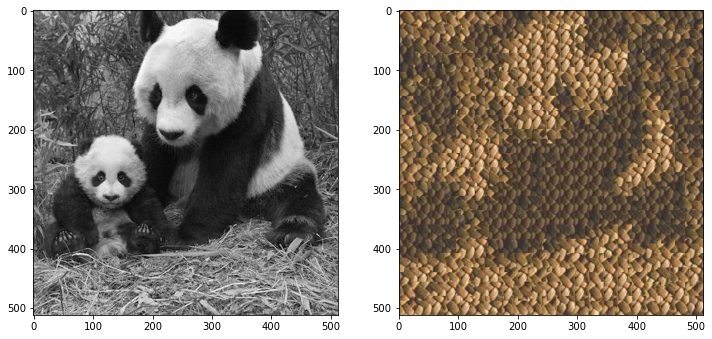

In [16]:
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(img,cmap='gray');
plt.subplot(1,2,2)
plt.imshow(out.astype('uint8'),cmap='gray');
iio.imwrite("q5/res26-texture.png",out.astype('uint8'))